# Location scale regression with smooth covariates 

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os 

# Set path such that interpreter finds tigerpy
sys.path.append(os.path.join(os.getcwd(), ".."))

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions import MultivariateNormalDegenerate

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd
import tensorflow_probability.substrates.jax.bijectors as tfjb

rng = np.random.default_rng(42)

# Load the data
df = pd.read_csv('../data/dbbmi.csv', sep=',')

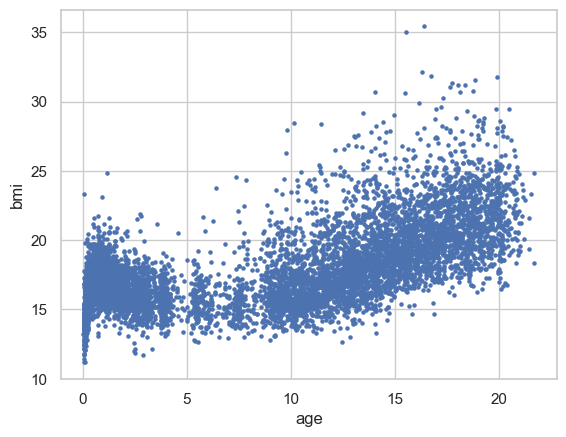

In [2]:
# Plot the data
sns.set_theme(style="whitegrid")
df.plot(kind = "scatter", x = "age", y = "bmi", s = 5)
plt.show()

In [56]:
# Define a model with intercept 
# Set up design matrix for loc
X = tiger.Obs(name="X", intercept=True)
X.smooth(data=df["age"].to_numpy(), n_knots=20)
# If we combine fixed covariates and smooth covariates we need to center the the smooth effects first 
X.center()

# Set up design matrix for scale 
Z = tiger.Obs(name="Z", intercept=True)
Z.smooth(data=df["age"].to_numpy(), n_knots=20)
# If we combine fixed covariates and smooth covariates we need to center the the smooth effects first 
Z.center()

# Linear Predictor for the location ----
# Fixed coefficents 
# Set up beta_fixed hyperparameters 
beta_loc = tiger.Hyper(0.0, name="beta_loc")
beta_scale = tiger.Hyper(100.0, name="beta_scale")

# Set up parameters
beta_dist = tiger.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=df["bmi"].to_numpy().mean(), distribution=beta_dist, name="beta")

# Smooth coefficients
# Set up hyperparameters for the beta_smooth_scale  
smooth1_tau2_a = tiger.Hyper(1.0, name="smooth1_tau2_a")
smooth1_tau2_b = tiger.Hyper(0.00005, name="smooth1_tau2_b")
smooth1_tau2_dist = tiger.Dist(tfjd.InverseGamma, concentration=smooth1_tau2_a, scale=smooth1_tau2_b)
smooth1_tau2 = tiger.Param(value=jnp.array([1.0]), distribution=smooth1_tau2_dist, param_space="positive", name="smooth1_tau2")

# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
smooth1_loc = tiger.Hyper(np.zeros(X.smooth_dim_cent[0]), name="smooth1_loc")
smooth1_pen = tiger.Hyper(X.smooth_pen_mat_cent[0], name="smooth1_pen")
# Set up parameters
smooth1_dist = tiger.Dist(MultivariateNormalDegenerate, loc=smooth1_loc, var=smooth1_tau2, pen=smooth1_pen)
smooth1 = tiger.Param(value=np.zeros(X.smooth_dim_cent[0]), distribution=smooth1_dist, name="smooth1")

# Set up the linear predictor
lpred_loc = tiger.Lpred(obs=X, beta_fixed=beta, beta_smooth=smooth1)

# Linear Predictor for the scale ----
# Fixed coefficents 
# Set up beta_fixed hyperparameters 
gamma_loc = tiger.Hyper(0.0, name="gamma_loc")
gamma_scale = tiger.Hyper(3.0, name="gamma_scale")

# Set up parameters
gamma_dist = tiger.Dist(tfjd.Normal, loc=gamma_loc, scale=gamma_scale)
gamma = tiger.Param(value=np.log(df["bmi"].to_numpy().std()), distribution=gamma_dist, name="gamma")

# Smooth coefficients
# Set up hyperparameters for the beta_smooth_scale  
smooth2_tau2_a = tiger.Hyper(1.0, name="smooth2_tau2_a")
smooth2_tau2_b = tiger.Hyper(0.00005, name="smooth2_tau2_b")
smooth2_tau2_dist = tiger.Dist(tfjd.InverseGamma, concentration=smooth2_tau2_a, scale=smooth2_tau2_b)
smooth2_tau2 = tiger.Param(value=jnp.array([1.0]), distribution=smooth2_tau2_dist, param_space="positive", name="smooth2_tau2")

# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
smooth2_loc = tiger.Hyper(np.zeros(Z.smooth_dim_cent[0]), name="smooth2_loc")
smooth2_pen = tiger.Hyper(Z.smooth_pen_mat_cent[0], name="smooth2_pen")
# Set up parameters
smooth2_dist = tiger.Dist(MultivariateNormalDegenerate, loc=smooth2_loc, var=smooth2_tau2, pen=smooth2_pen)
smooth2 = tiger.Param(value=np.zeros(Z.smooth_dim_cent[0]), distribution=smooth2_dist, name="smooth2")

# ----
# Set up the linear predictor
lpred_scale = tiger.Lpred(obs=Z, gamma_fixed=gamma, gamma_smooth=smooth2, function=jnp.exp)

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred_loc, scale=lpred_scale)
m = tiger.Model(response=df["bmi"].to_numpy(), distribution=response_dist)

In [57]:
m.log_prob

Array(-18190.56, dtype=float32)

In [58]:
m.log_prior

Array(-56.666077, dtype=float32)

In [59]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

In [60]:
graph.sum_logpriors()

Array(-56.66608, dtype=float32)

In [61]:
graph.logprob()

Array(-18190.56, dtype=float32)

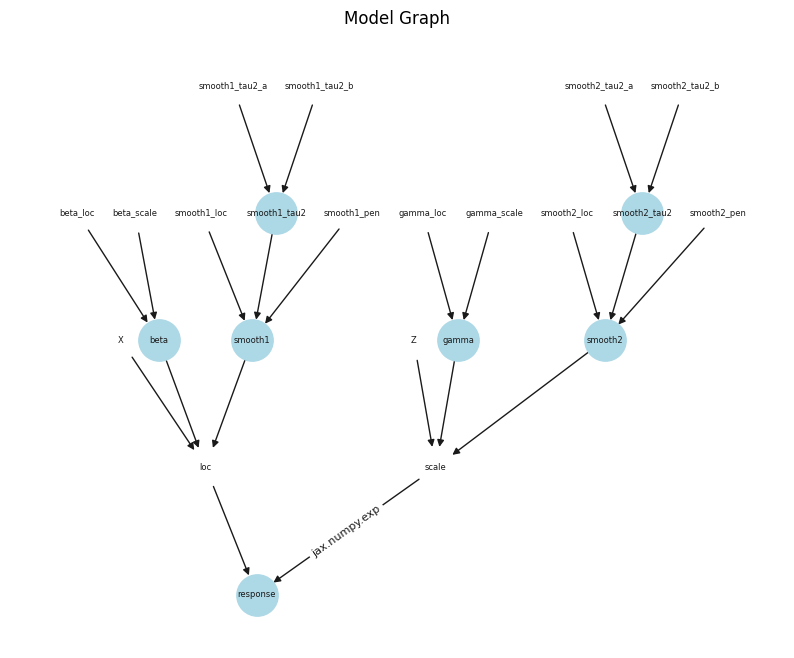

In [62]:
graph.visualize_graph()

## Test inference functions

In [147]:
import tigerpy.distributions.mvn as mvn
from tigerpy.bbvi.transform import (
    log_cholesky_parametrization_to_tril
)

In [148]:
q = bbvi.Bbvi(graph=graph, 
              model_init=True,
              loc_prec=10.0,
              scale_prec=10.0)
key = jax.random.PRNGKey(27)
key, *subkeys = jax.random.split(key, len(q.init_var_params)+1)

In [85]:
# Obtain the variational parameters 
# Parameters location 
loc_beta_fixed, log_chol_prec_beta_fixed = q.init_var_params["beta_fixed"]["loc"], q.init_var_params["beta_fixed"]["log_cholesky_prec"]
loc_beta_smooth, log_chol_prec_beta_smooth = q.init_var_params["beta_smooth"]["loc"], q.init_var_params["beta_smooth"]["log_cholesky_prec"]
loc_tau2, log_chol_prec_tau2= q.init_var_params["tau2"]["loc"], q.init_var_params["tau2"]["log_cholesky_prec"]

# Parameters scale
loc_gamma_fixed, log_chol_prec_gamma_fixed = q.init_var_params["gamma_fixed"]["loc"], q.init_var_params["gamma_fixed"]["log_cholesky_prec"]
loc_gamma_smooth, log_chol_prec_gamma_smooth = q.init_var_params["gamma_smooth"]["loc"], q.init_var_params["gamma_smooth"]["log_cholesky_prec"]
loc_eta2, log_chol_prec_eta2 = q.init_var_params["eta2"]["loc"], q.init_var_params["eta2"]["log_cholesky_prec"]

In [86]:
# Obtain the lower triangular matrices of the 
# Parameters location 
lower_tri_beta_fixed = log_cholesky_parametrization_to_tril(log_chol_prec_beta_fixed, d=loc_beta_fixed.shape[0])
lower_tri_beta_smooth = log_cholesky_parametrization_to_tril(log_chol_prec_beta_smooth, d=loc_beta_smooth.shape[0])
lower_tri_tau2 = log_cholesky_parametrization_to_tril(log_chol_prec_tau2, d=loc_tau2.shape[0])

# Parameters scale
lower_tri_gamma_fixed = log_cholesky_parametrization_to_tril(log_chol_prec_gamma_fixed, d=loc_gamma_fixed.shape[0])
lower_tri_gamma_smooth = log_cholesky_parametrization_to_tril(log_chol_prec_gamma_smooth, d=loc_gamma_smooth.shape[0])
lower_tri_eta2 = log_cholesky_parametrization_to_tril(log_chol_prec_eta2, d=loc_eta2.shape[0])

In [87]:
# Obtain samples from the variational distributions
# Parameters location
samples_beta_fixed = mvn.mvn_precision_chol_sample(loc=loc_beta_fixed, precision_matrix_chol=lower_tri_beta_fixed, key=subkeys[0], S=64)
samples_beta_smooth = mvn.mvn_precision_chol_sample(loc=loc_beta_smooth, precision_matrix_chol=lower_tri_beta_smooth, key=subkeys[1], S=64)
samples_tau2 = mvn.mvn_precision_chol_sample(loc=loc_tau2, precision_matrix_chol=lower_tri_tau2, key=subkeys[2], S=64)

# Parameters scale 
samples_gamma_fixed = mvn.mvn_precision_chol_sample(loc=loc_gamma_fixed, precision_matrix_chol=lower_tri_gamma_fixed, key=subkeys[3], S=64)
samples_gamma_smooth = mvn.mvn_precision_chol_sample(loc=loc_gamma_smooth, precision_matrix_chol=lower_tri_gamma_smooth, key=subkeys[4], S=64)
samples_eta2 = mvn.mvn_precision_chol_sample(loc=loc_eta2, precision_matrix_chol=lower_tri_eta2, key=subkeys[5], S=64)

In [88]:
# Store all the variational samples in a dict
test_samples = {"beta_fixed": samples_beta_fixed,
                "beta_smooth": samples_beta_smooth,
                "tau2": jnp.exp(samples_tau2),
                "gamma_fixed": samples_gamma_fixed,
                "gamma_smooth": samples_gamma_smooth,
                "eta2": jnp.exp(samples_eta2)}

In [89]:
for kw, value in test_samples.items():
    print(jnp.mean(value, axis=0))

[18.049301]
[-2.847191   -2.6443276  -1.1175969  -2.710309   -2.3676863  -2.078587
 -1.6715817  -1.3118851  -1.2660825  -0.5381671  -0.09688176  0.37090755
  1.222198    1.4731107   2.1465335   2.8264961   3.3799405   3.6745744
  3.9342732 ]
[1.0155115]
[0.57723886]
[-0.59307826 -0.26170284 -0.30631584 -0.29354334 -0.1956428  -0.35217756
  0.09642696 -0.00877103  0.08588633  0.17973754  0.29626393  0.07764284
  0.46467042  0.09353741  0.17983398  0.29134423  0.38064378  0.35836598
  0.30985785]
[1.0045741]


In [90]:
batch_idx = jax.random.choice(key, q.num_obs, (128,), replace=False)

In [91]:
data_new = jax.tree_map(lambda x: x[batch_idx], q.data)

In [92]:
graph.logprob()

Array(-18190.56, dtype=float32)

In [93]:
q.mc_logprob(data_new,  test_samples, q.num_obs)

Array(-16041.751, dtype=float32)

In [83]:
q.lower_bound(q.init_var_params, 
              data_new,
              num_obs=q.num_obs,
              num_var_samples=64,
              key=key)

Array(20638.072, dtype=float32)

## Inference with Bbvi

In [90]:
q = bbvi.Bbvi(graph=graph,
              model_init=True,
              loc_prec=3.0,
              scale_prec=10.0)

In [91]:
key = jax.random.PRNGKey(400)
q.run_bbvi(key=key,
           learning_rate=0.01,
           grad_clip=1,
           threshold=1e-2,
           batch_size=512,
           train_share=0.8,
           num_var_samples=64,
           chunk_size=50,
           epochs=500)

Start optimization ...
Finished optimization.


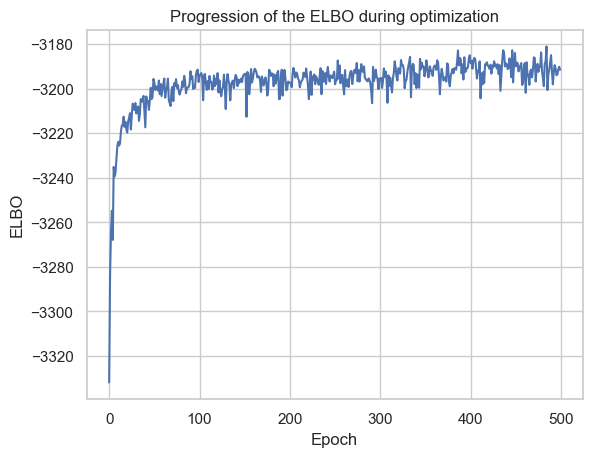

In [92]:
q.plot_elbo()

## Visualize the regression line 

In [93]:
b = q.trans_var_params["beta"]["loc"]
g = q.trans_var_params["smooth1"]["loc"]

In [94]:
# Location
# for fixed and smooth terms
beta_post = q.trans_var_params["beta"]["loc"]
smooth1_post = q.trans_var_params["smooth1"]["loc"]
loc_post = jnp.concatenate((beta_post, smooth1_post))
y_loc = X.design_matrix @ loc_post
# Scale 
gamma_post = q.trans_var_params["gamma"]["loc"]
smooth2_post = q.trans_var_params["smooth2"]["loc"]
scale_post = jnp.concatenate((gamma_post, smooth2_post))
y_scale = jnp.exp(Z.design_matrix @ scale_post)

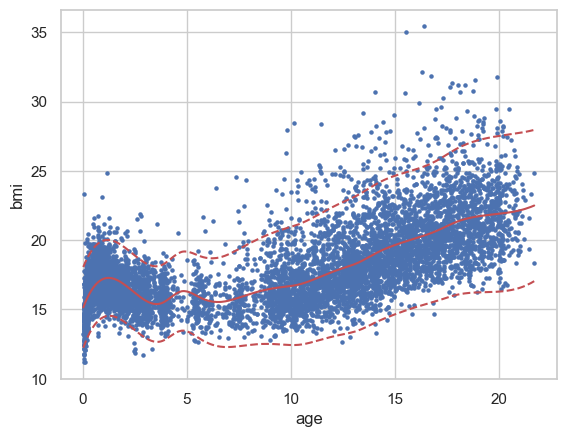

In [95]:
# plot the data
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

df.plot(kind="scatter", x="age", y="bmi", s=5, ax=ax)
ax.plot(df["age"].to_numpy(), y_loc, color = "r")
ax.plot(df["age"].to_numpy(), y_loc - 1.96*y_scale, color = "r", linestyle="--")
ax.plot(df["age"].to_numpy(), y_loc + 1.96*y_scale, color = "r", linestyle="--")
plt.show()

In [96]:
tau2 = q.trans_var_params["smooth1_tau2"]["loc"]
eta2 = q.trans_var_params["smooth2_tau2"]["loc"]

In [97]:
1/tau2

Array([0.9212388], dtype=float32)

In [98]:
1/eta2

Array([407.1928], dtype=float32)